Grad-CAm example from:

https://keras.io/examples/vision/grad_cam/

Copied on 26/7/2024
for applying to the model of lungs.

V0: adapt to my model and data.
* link to the latest CNN model V2_1,
* replace the name of last conv layer ,
* load a radio image and mask of COVID from validation set,
* replace 'get_img_array' and 'keras.applications.xception.preprocess_input'
  by my own function (image, mask) -> 128 x 128 x 2 of numbers in [0,1],
* remove 'decode_predictions'

_Résultats_ (les indices sont ceux d'images COVID dans les données validation):

* 4 = COVID-2980 (3 zones clairement identifiées, dont deux appartiennent aux poumons),
* 10 = COVID-1499 (il a colorié presque tout le corps, un bord du poumon gauche et la bouche sortent du lot).
* 19 = COVID-2495 (tout ce qui est au-dessus des épaules et quelques points dans les poumons)
* 26 = COVID-3583 (des bouts de poumons, surtout du poumon droit) et des traces de ce qui se trouve en-dehors du corps.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from load_images_from_CSV_v2 import load_img_mask
import pandas as pd

2024-07-29 14:13:12.810797: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 14:13:12.966306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configurable parameters

You can change these to another model.

To get the values for last_conv_layer_name use model.summary() to see the names of all layers in the model.

('../data/COVID/images/COVID-3583.png', '../data/COVID/masks/COVID-3583.png')


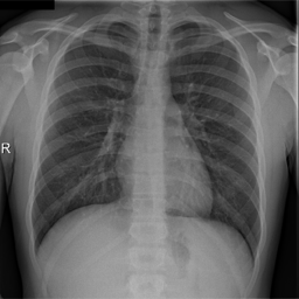

In [2]:
# model_builder = keras.applications.xception.Xception
# img_size = (299, 299)
# ->
img_size = (128, 128)

# preprocess_input = keras.applications.xception.preprocess_input


decode_predictions = keras.applications.xception.decode_predictions

# last_conv_layer_name = "block14_sepconv2_act"
# ->
last_conv_layer_name = "conv3"


# The local path to our target image
"""
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

img_path = keras.utils.get_file(
    fname="african_elephant.jpg", origin="https://i.imgur.com/Bvro0YD.png"
)
"""
# These attempts fail : "https://i.imgur.com/Bvro0YD.png"
# https://imgur.com/trunk-lessons-can-take-up-to-year-baby-elephant-to-learn-to-use-trunk-well-enough-to-grasp-eat-drink-Bvro0YD

# img_path = keras.utils.get_file("african_elephant.png")
"""
img_path = keras.utils.get_file(
    fname="african_elephant.jpg", origin="file:///home/Apprentissage/DataScientest/DS_2024/final_project/notebooks_select1/example_grad_cam/african_elephant.png"
)
# "https://drive.google.com/file/d/1Qr0_10oME7xoMumratF54q8LkelLBhXK/view?usp=sharing"
# No error message, but no image either...

# "file:///home/Apprentissage/DataScientest/DS_2024/final_project/notebooks_select1/example_grad_cam/african_elephant.png":
# same result...
"""

idx_im = 26  # The index in validation set can be modified.


path_data = "../data"
path_list_files = '../src/models/datasets1_2/img_val.csv'
df_data = pd.read_csv(path_list_files)
row_data = df_data.iloc[idx_im, :]
scan_path = os.path.join(path_data, row_data['img_folder'], row_data['Images'])
mask_path = os.path.join(path_data, row_data['mask_folder'], row_data['Masks'])
img_path = (scan_path, mask_path)


print(img_path)
display(Image(img_path[0]))

# -> 

# The Grad-CAM algorithm

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    # https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [4]:
# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
# -> TOADAPT preprocessing
img_array = load_img_mask(img_path, new_size=img_size)


# Make model
# model = model_builder(weights="imagenet")
# ->
dir_model = "../models"
path_model = os.path.join(dir_model, "model2_1_3layers.keras")
model = tf.keras.models.load_model(path_model)
# TOCHECK


# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])
# Imported at:
# decode_predictions = keras.applications.xception.decode_predictions
# ->
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# added printouts:
print('--------------')
print(heatmap.shape)  # (10, 10)
print(model.summary())
# Plusieurs blocks de type (Separable Conv2D), (BatchNormalization), (Activation)
# last_conv_layer_name = "block14_sepconv2_act"
# La taille après cette couche est: (None, 10, 10, 2048).

1/1 [==============================] - 0s 99ms/step
Predicted: [[ 0.7436281   0.18089025 -0.5451321 ]]
--------------
(28, 28)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 124, 124, 30)      1530      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 30)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 60, 60, 16)        4336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 28, 28, 16)        2320  

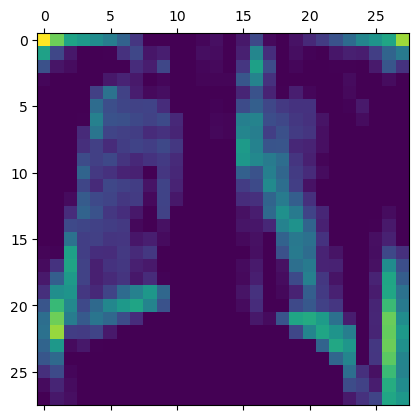

In [5]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

Create a superimposed visualization

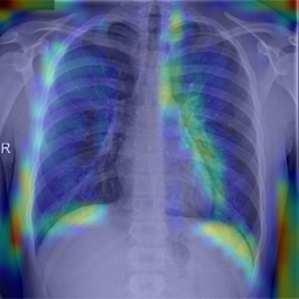

In [6]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam_v0.jpg", alpha=0.4):
    # Load the original image
    # img = keras.utils.load_img(img_path)
    #->
    img = keras.utils.load_img(img_path[0])
    img = keras.utils.img_to_array(img)

    # cam_path = "cam_img_" + str(idx_im) + ".jpg"
    cam_path = "cam_img_" + os.path.split(img_path[0])[1]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))
    display(superimposed_img)

save_and_display_gradcam(img_path, heatmap)
